In [1]:
import numpy as np
import pandas as pd

from catboost import CatBoostClassifier, Pool, CatBoostRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

import os
import sys
BASE_PATH = os.path.realpath('..')
DATASETS_DIR = os.path.join(BASE_PATH, 'datasets')
LIB_DIR = os.path.join(BASE_PATH,'lib')
if LIB_DIR[:-3] not in sys.path:
    sys.path.append(LIB_DIR[:-3])

import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm

from importlib import reload

In [2]:
import scipy as sp

In [3]:
RESULTS_DIR = os.path.join(BASE_PATH, 'results')

In [4]:
from lib import fca_interp as fcai
from lib.utils_ import powerset, sparse_unique_columns
from importlib import reload

In [5]:
from importlib import reload

In [6]:
from copy import copy, deepcopy

# Load Data

In [7]:
data_dict = {}

## Adult DS

In [8]:
adult_ds = pd.read_csv(DATASETS_DIR+'/adult/adult.data', header=None)
fs = ['age','workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'occupation',
      'relationship', 'race', 'sex', 'capital-gain', 'capital-loss','hours-per-week','native-country',
      'y']
adult_ds.columns = fs
adult_ds['y_bin'] = (adult_ds['y']==' >50K').astype(int)
cat_feats = ['workclass','education','marital-status','occupation','relationship','race','sex','native-country']
y_feat = 'y_bin'
train_feats = ['age','workclass','fnlwgt','education','education-num','marital-status','occupation','relationship','race','sex','capital-loss','native-country']
adult_ds.drop(train_feats,1)

print(adult_ds.shape)
adult_ds.head(2)

(32561, 16)


,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,y,y_bin
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K,0
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K,0


In [9]:
data_dict['adult'] = {'ds':adult_ds, 'train_feats':train_feats, 'cat_feats':cat_feats, 'y_feat':y_feat,}

## Amazon DS

In [10]:
amaz_ds = pd.read_csv(DATASETS_DIR+'/amazon/train.csv')
y_feat = 'ACTION'
train_feats = ['MGR_ID','ROLE_ROLLUP_1','ROLE_ROLLUP_2','ROLE_DEPTNAME',
               'ROLE_TITLE','ROLE_FAMILY_DESC','ROLE_FAMILY','ROLE_CODE']
cat_feats = []

print(amaz_ds.shape)
amaz_ds.head()

(32769, 10)


,ACTION,RESOURCE,MGR_ID,ROLE_ROLLUP_1,ROLE_ROLLUP_2,ROLE_DEPTNAME,ROLE_TITLE,ROLE_FAMILY_DESC,ROLE_FAMILY,ROLE_CODE
0,1,39353,85475,117961,118300,123472,117905,117906,290919,117908
1,1,17183,1540,117961,118343,123125,118536,118536,308574,118539
2,1,36724,14457,118219,118220,117884,117879,267952,19721,117880
3,1,36135,5396,117961,118343,119993,118321,240983,290919,118322
4,1,42680,5905,117929,117930,119569,119323,123932,19793,119325


In [11]:
data_dict['amazon'] = {'ds':amaz_ds, 'train_feats':train_feats, 'cat_feats':cat_feats, 'y_feat':y_feat}

## Bank DS

In [12]:
bank_ds = pd.read_csv(DATASETS_DIR+'/bank/bank.csv', sep=';')
for f in ['default','housing','loan','y']:
    bank_ds[f] = (bank_ds[f]=='yes').astype(int)
train_feats = ['age','job','marital','education','default','balance',
               'housing','loan','contact','day','month','duration','campaign','pdays','previous','poutcome']
cat_feats = ['job','marital','education','contact','month','poutcome']
y_feat = 'y'
print(bank_ds.shape)
bank_ds.head()

(4521, 17)


,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,30,unemployed,married,primary,0,1787,0,0,cellular,19,oct,79,1,-1,0,unknown,0
1,33,services,married,secondary,0,4789,1,1,cellular,11,may,220,1,339,4,failure,0
2,35,management,single,tertiary,0,1350,1,0,cellular,16,apr,185,1,330,1,failure,0
3,30,management,married,tertiary,0,1476,1,1,unknown,3,jun,199,4,-1,0,unknown,0
4,59,blue-collar,married,secondary,0,0,1,0,unknown,5,may,226,1,-1,0,unknown,0


In [13]:
data_dict['bank'] = {'ds':bank_ds, 'train_feats':train_feats, 'cat_feats':cat_feats, 'y_feat':y_feat}

## Breast cancer

In [14]:
breast_ds = pd.read_csv(DATASETS_DIR+'/breast_cancer/breast-cancer-wisconsin.data', header=None)
fs = ['Sample_code','Clump_Thickness','Uniformity_of_Cell_Size','Uniformity_of_Cell_Shape','Marginal_Adhesion',
     'Single_Epithelial_Cell_Size','Bare_Nuclei','Bland_Chromatin','Normal_Nucleoli','Mitoses','Class']
breast_ds.columns = fs
breast_ds['Bare_Nuclei'] = [int(x) if x!='?' else -1 for x in breast_ds['Bare_Nuclei']]

breast_ds['y'] = (breast_ds['Class']-2)//2
train_feats = ['Clump_Thickness','Uniformity_of_Cell_Size','Uniformity_of_Cell_Shape','Marginal_Adhesion',
     'Single_Epithelial_Cell_Size','Bare_Nuclei','Bland_Chromatin','Normal_Nucleoli','Mitoses',]
cat_feats = []
y_feat = 'y'

print(breast_ds.shape)
breast_ds.head()

(699, 12)


,Sample_code,Clump_Thickness,Uniformity_of_Cell_Size,Uniformity_of_Cell_Shape,Marginal_Adhesion,Single_Epithelial_Cell_Size,Bare_Nuclei,Bland_Chromatin,Normal_Nucleoli,Mitoses,Class,y
0,1000025,5,1,1,1,2,1,3,1,1,2,0
1,1002945,5,4,4,5,7,10,3,2,1,2,0
2,1015425,3,1,1,1,2,2,3,1,1,2,0
3,1016277,6,8,8,1,3,4,3,7,1,2,0
4,1017023,4,1,1,3,2,1,3,1,1,2,0


In [15]:
data_dict['breast'] = {'ds':breast_ds, 'train_feats':train_feats, 'cat_feats':cat_feats, 'y_feat':y_feat}

## Credit Card Default

In [16]:
credit_ds = pd.read_excel(DATASETS_DIR+'/creditCardDefault/default of credit card clients.xls', header=1)
train_feats = ['LIMIT_BAL', 'SEX', 'EDUCATION', 'MARRIAGE', 'AGE', 'PAY_0',
       'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 'BILL_AMT1', 'BILL_AMT2',
       'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1',
       'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6']
cat_feats = []
y_feat = 'default payment next month'
print(credit_ds.shape)
credit_ds.head(2)

(30000, 25)


,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default payment next month
0,1,20000,2,2,1,24,2,2,-1,-1,...,0,0,0,0,689,0,0,0,0,1
1,2,120000,2,2,2,26,-1,2,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1


In [17]:
data_dict['credit'] = {'ds':credit_ds, 'train_feats':train_feats, 'cat_feats':cat_feats, 'y_feat':y_feat}

## Heart disease

In [18]:
heart_ds = pd.concat([pd.read_csv(DATASETS_DIR+f'/heart_disease/processed.{x}.data', header=None)
                      for x in ['cleveland','hungarian','switzerland','va']])
heart_ds.index = range(len(heart_ds))
fs = ['age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg',
      'thalach', 'exang', 'oldpeak', 'slope', 'ca', 'thal', 'num']
train_feats = ['age','sex','cp','trestbps','chol','fbs','restecg','thalach','exang','oldpeak','slope','ca','thal']
cat_feats = []
heart_ds.columns = fs
for f in ['trestbps', 'chol', 'fbs', 'restecg', 'thalach', 'exang', 'oldpeak',
       'slope', 'ca', 'thal']:
    heart_ds[f] = [float(x) if x!='?' else -1 for x in heart_ds[f]] 
heart_ds['has_disease'] = (heart_ds['num']>0).astype(int)
y_feat = 'has_disease'
print(heart_ds.shape)
heart_ds.head()

(920, 15)


,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num,has_disease
0,63.0,1.0,1.0,145.0,233.0,1.0,2.0,150.0,0.0,2.3,3.0,0.0,6.0,0,0
1,67.0,1.0,4.0,160.0,286.0,0.0,2.0,108.0,1.0,1.5,2.0,3.0,3.0,2,1
2,67.0,1.0,4.0,120.0,229.0,0.0,2.0,129.0,1.0,2.6,2.0,2.0,7.0,1,1
3,37.0,1.0,3.0,130.0,250.0,0.0,0.0,187.0,0.0,3.5,3.0,0.0,3.0,0,0
4,41.0,0.0,2.0,130.0,204.0,0.0,2.0,172.0,0.0,1.4,1.0,0.0,3.0,0,0


In [19]:
data_dict['heart'] = {'ds':heart_ds, 'train_feats':train_feats, 'cat_feats':cat_feats, 'y_feat':y_feat}

## KDD

## Kick

In [20]:
kick_ds = pd.read_csv(DATASETS_DIR+'/kick/training.csv')
print(kick_ds.shape)
kick_ds.head()

(72983, 34)


,RefId,IsBadBuy,PurchDate,Auction,VehYear,VehicleAge,Make,Model,Trim,SubModel,...,MMRCurrentRetailAveragePrice,MMRCurrentRetailCleanPrice,PRIMEUNIT,AUCGUART,BYRNO,VNZIP1,VNST,VehBCost,IsOnlineSale,WarrantyCost
0,1,0,12/7/2009,ADESA,2006,3,MAZDA,MAZDA3,i,4D SEDAN I,...,11597.0,12409.0,NaN,NaN,21973,33619,FL,7100.0,0,1113
1,2,0,12/7/2009,ADESA,2004,5,DODGE,1500 RAM PICKUP 2WD,ST,QUAD CAB 4.7L SLT,...,11374.0,12791.0,NaN,NaN,19638,33619,FL,7600.0,0,1053
2,3,0,12/7/2009,ADESA,2005,4,DODGE,STRATUS V6,SXT,4D SEDAN SXT FFV,...,7146.0,8702.0,NaN,NaN,19638,33619,FL,4900.0,0,1389
3,4,0,12/7/2009,ADESA,2004,5,DODGE,NEON,SXT,4D SEDAN,...,4375.0,5518.0,NaN,NaN,19638,33619,FL,4100.0,0,630
4,5,0,12/7/2009,ADESA,2005,4,FORD,FOCUS,ZX3,2D COUPE ZX3,...,6739.0,7911.0,NaN,NaN,19638,33619,FL,4000.0,0,1020


In [21]:
train_feats = ['Auction', 'VehYear', 'VehicleAge',
       'Make', 'Model', 'Trim', 'SubModel', 'Color', 'Transmission',
       'WheelTypeID', 'WheelType', 'VehOdo', 'Nationality', 'Size',
       'TopThreeAmericanName', 'MMRAcquisitionAuctionAveragePrice',
       'MMRAcquisitionAuctionCleanPrice', 'MMRAcquisitionRetailAveragePrice',
       'MMRAcquisitonRetailCleanPrice', 'MMRCurrentAuctionAveragePrice',
       'MMRCurrentAuctionCleanPrice', 'MMRCurrentRetailAveragePrice',
       'MMRCurrentRetailCleanPrice', 'PRIMEUNIT', 'AUCGUART', 'BYRNO',
       'VNZIP1', 'VNST', 'VehBCost', 'IsOnlineSale', 'WarrantyCost']
cat_feats = ['Auction','VehYear', 'Make', 'Model', 'Trim', 'SubModel', 'Color', 'Transmission',
       'WheelType', 'Nationality', 'Size','PRIMEUNIT','AUCGUART',
       'TopThreeAmericanName',  'VNST',]
y_feat = 'IsBadBuy'

In [22]:
kick_ds[cat_feats] = kick_ds[cat_feats].fillna('NONE')

In [23]:
kick_ds[[f for f in kick_ds.columns if f not in cat_feats]] = kick_ds.drop(cat_feats,1).fillna(-1)

In [24]:
data_dict['kick'] = {'ds':kick_ds, 'train_feats':train_feats, 'cat_feats':cat_feats, 'y_feat':y_feat}

## Mammographic Mass

In [25]:
mamm_ds = pd.read_csv(DATASETS_DIR+'/mammographic_mass/mammographic_masses.data', header=None)
fs = ['BI-RADS assessment', 'Age', 'Shape', 'Margin', 'Density','Severity']
mamm_ds.columns = fs
for f in fs:
    mamm_ds[f] = [float(x) if x!='?' else -1 for x in mamm_ds[f]]
print(mamm_ds.shape)
mamm_ds.head()

(961, 6)


,BI-RADS assessment,Age,Shape,Margin,Density,Severity
0,5.0,67.0,3.0,5.0,3.0,1.0
1,4.0,43.0,1.0,1.0,-1.0,1.0
2,5.0,58.0,4.0,5.0,3.0,1.0
3,4.0,28.0,1.0,1.0,3.0,0.0
4,5.0,74.0,1.0,5.0,-1.0,1.0


In [26]:
train_feats = ['BI-RADS assessment','Age','Shape','Margin','Density']
y_feat = 'Severity'
cat_feats = []

In [27]:
data_dict['mammograph'] = {'ds':mamm_ds, 'train_feats':train_feats, 'cat_feats':cat_feats, 'y_feat':y_feat}

## Seismic bumps

In [28]:
from scipy.io import arff

seism_ds = pd.DataFrame(arff.loadarff(DATASETS_DIR+'/seismic_bumps/seismic-bumps.arff')[0])
seism_ds['class_bin'] = (seism_ds['class']==b'1').astype(int)
print(seism_ds.shape)
seism_ds.head()

(2584, 20)


,seismic,seismoacoustic,shift,genergy,gpuls,gdenergy,gdpuls,ghazard,nbumps,nbumps2,nbumps3,nbumps4,nbumps5,nbumps6,nbumps7,nbumps89,energy,maxenergy,class,class_bin
0,b'a',b'a',b'N',15180.0,48.0,-72.0,-72.0,b'a',0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,b'0',0
1,b'a',b'a',b'N',14720.0,33.0,-70.0,-79.0,b'a',1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,2000.0,2000.0,b'0',0
2,b'a',b'a',b'N',8050.0,30.0,-81.0,-78.0,b'a',0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,b'0',0
3,b'a',b'a',b'N',28820.0,171.0,-23.0,40.0,b'a',1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,3000.0,3000.0,b'0',0
4,b'a',b'a',b'N',12640.0,57.0,-63.0,-52.0,b'a',0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,b'0',0


In [29]:
train_feats = ['seismic', 'seismoacoustic', 'shift', 'genergy', 'gpuls', 'gdenergy',
       'gdpuls', 'ghazard', 'nbumps', 'nbumps2', 'nbumps3', 'nbumps4',
       'nbumps5', 'nbumps6', 'nbumps7', 'nbumps89', 'energy', 'maxenergy',]
cat_feats = ['seismic','seismoacoustic','shift','ghazard']
y_feat = 'class_bin'

In [30]:
data_dict['seismic'] = {'ds':seism_ds, 'train_feats':train_feats, 'cat_feats':cat_feats, 'y_feat':y_feat}

# Test RF with weights

In [52]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

In [53]:
def ds_to_ohe(X_train, X_test, cat_feats):
    X_train_ohe, X_test_ohe = X_train.copy(), X_test.copy()
    for f in cat_feats:
        for v in X_train_ohe[f].unique():
            X_train_ohe[f"{f}__{v}"] = X_train[f]==v
            X_test_ohe[f"{f}__{v}"] = X_test[f]==v
        X_train_ohe = X_train_ohe.drop(f,1)
        X_test_ohe = X_test_ohe.drop(f, 1)
    return X_train_ohe, X_test_ohe

In [217]:
data_name = 'adult'
data = data_dict[data_name]
ds, train_feats, cat_feats, y_feat = data['ds'], data['train_feats'], data['cat_feats'], data['y_feat']

In [218]:
X_train, X_test, y_train, y_test = train_test_split(ds[train_feats], ds[y_feat])

In [219]:
X_train_ohe, X_test_ohe = ds_to_ohe(X_train, X_test, cat_feats)

In [220]:
cntx_train = fcai.MultiValuedContext(X_train, objs=[str(x) for x in X_train.index], y_true=y_train, cat_attrs=cat_feats)
cntx_test = fcai.MultiValuedContext(X_test, objs=[str(x) for x in X_test.index], y_true=y_test, cat_attrs=cat_feats)
fm = fcai.FormalManager(cntx_train)

In [384]:
fm.construct_concepts(algo='RandomForest', rf_params={'n_estimators':10, 'max_depth':10, 'random_state':42}, n_layers=1)
fm.construct_lattice(only_spanning_tree=True, use_tqdm=True)

In [385]:
from scipy.sparse import csr_matrix

In [386]:
preds_cur_train = fm.predict_context(cntx_train).flatten().tolist()[0]
preds_cur_test = fm.predict_context(cntx_test).flatten().tolist()[0]

In [387]:
metric = 'mean_y_true'

In [388]:
def calc_threshold(y, preds, metric, ths):
    return ths[np.argmax([metric(y, preds>t) for t in ths])]

In [389]:
n_objs, n_cncpts = len(obj_preds_cncpts), len(fm.get_concepts())

In [451]:
def predict_fca(fm, cntx, metric, W, use_logit=False):
    metric = metric if type(metric) == list else [metric]
    mvals = np.array(
        [[c._metrics[m] for m in metric] for c in sorted(fm.get_concepts(), key=lambda c: c.get_id())])
    
    m_id = 0    
    
    obj_preds_cncpts = fm.trace_context(cntx)[0]
    n_objs, n_cncpts = len(obj_preds_cncpts), len(fm.get_concepts())
    
    X_ = np.array([(mvals[c_id][m_id] if not use_logit
                    else min(max(logit(mvals[c_id][m_id]), -100),100),
                    g, c_id)
                   for g, c_ids in obj_preds_cncpts.items() for c_id in c_ids])
    X = csr_matrix((X_[:, 0], (X_[:, 1].astype(int), X_[:, 2].astype(int))),
            shape=(n_objs, n_cncpts))
    
    preds = X.dot(W)#/(X>0).dot(W) 
    return preds, X

In [391]:
def logit(p):
    return np.log(p/(1-p))

def sigmoid(x):
    return 1/(1+np.exp(-x))

In [452]:
W0 =  np.ones(n_cncpts)/n_cncpts #np.ones(n_cncpts)

In [453]:
preds_train_0, X_train_0 = predict_fca(fm, cntx_train, 'mean_y_true', W0, use_logit=True)
preds_train_0 = sigmoid(preds_train_0)

In [454]:
th = calc_threshold(y_train, preds_train_0, f1_score, ths)
th

0.5

In [455]:
preds_test_0, X_test_0 = predict_fca(fm, cntx_test, 'mean_y_true', W0, use_logit=True)
preds_test_0 = sigmoid(preds_test_0)

In [456]:
f1_score(y_train, preds_train_0>th), f1_score(y_test, preds_test_0>th)

(0.5890746459375998, 0.5483247422680412)

In [457]:
th_cur = calc_threshold(y_train, preds_cur_train, f1_score, ths)

In [458]:
f1_score(y_train, preds_cur_train>th_cur), f1_score(y_test, preds_cur_test>th_cur)

(0.6695099255583126, 0.6549130230371415)

In [402]:
rf = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42)
rf.fit(X_train_ohe, y_train)
preds_rf_train = rf.predict(X_train_ohe)
preds_rf_test = rf.predict(X_test_ohe)

In [403]:
f1_score(y_train, preds_rf_train), f1_score(y_test, preds_rf_test)

(0.5977083333333333, 0.5776532835356365)

In [459]:
from sklearn.linear_model import LogisticRegression

In [460]:
lr = LogisticRegression()

In [461]:
(X_train_0==-np.inf)

<24420x3178 sparse matrix of type '<class 'numpy.bool_'>'
	with 0 stored elements in Compressed Sparse Row format>

In [462]:
lr.fit(X_train_0, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [463]:
W_lr = lr.coef_[0]

In [464]:
preds_train_lr, X_train_lr = predict_fca(fm, cntx_train, 'mean_y_true', W_lr, use_logit=True)
preds_train_lr = sigmoid(preds_train_lr)

In [468]:
th_lr = calc_threshold(y_train, preds_train_lr, f1_score, ths)
th_lr

0.35000000000000003

In [469]:
preds_test_lr, X_test_lr = predict_fca(fm, cntx_test, 'mean_y_true', W_lr, use_logit=True)
preds_test_lr = sigmoid(preds_test_lr)

In [470]:
f1_score(y_train, preds_train_lr>th_lr), f1_score(y_test, preds_test_lr>th_lr)

(0.7157618753855645, 0.6382604875905996)

In [474]:
from scipy.optimize import nnls, lsq_linear

In [505]:
lsq = lsq_linear(X_train_0, y_train, bounds=(0, 1), verbose=2, max_iter=100)
lsq

   Iteration        Cost      Cost reduction    Step norm     Optimality   
       0         1.2442e+06                                    3.21e+05    
       1         8.2804e+05      4.16e+05       1.18e-01       5.54e+04    
       2         6.6531e+05      1.63e+05       1.35e+00       4.45e+04    
       3         5.2116e+05      1.44e+05       8.26e-02       1.87e+04    
       4         4.3270e+05      8.85e+04       7.77e-02       1.05e+04    
       5         3.6862e+05      6.41e+04       7.20e-02       6.56e+03    
       6         3.1996e+05      4.87e+04       6.72e-02       4.68e+03    
       7         2.8182e+05      3.81e+04       6.31e-02       3.53e+03    
       8         2.5102e+05      3.08e+04       6.56e-01       3.15e+03    
       9         2.2367e+05      2.73e+04       5.64e-02       3.05e+03    
      10         2.0114e+05      2.25e+04       5.37e-02       2.95e+03    
      11         1.8223e+05      1.89e+04       5.15e-02       2.85e+03    
      12    

 active_mask: array([0, 0, 0, ..., 0, 0, 0])
        cost: 2648.531106088235
         fun: array([-0.08000401, -0.03664303, -0.23779436, ..., -0.10161593,
       -0.13413365, -0.31468795])
     message: 'The maximum number of iterations is exceeded.'
         nit: 100
  optimality: 13.282210611039682
      status: 0
     success: False
           x: array([0.1       , 0.1       , 0.1       , ..., 0.01809011, 0.01699897,
       0.02589045])

In [506]:
W_lsq = lsq.x

In [507]:
preds_train_lsq, X_train_lsq = predict_fca(fm, cntx_train, 'mean_y_true', W_lsq, use_logit=True)
preds_train_lsq = sigmoid(preds_train_lsq)

In [508]:
th_lsq = calc_threshold(y_train, preds_train_lsq, f1_score, ths)
th_lsq

0.51

In [509]:
preds_test_lsq, X_test_lsq = predict_fca(fm, cntx_test, 'mean_y_true', W_lsq, use_logit=True)
preds_test_lsq = sigmoid(preds_test_lsq)

In [510]:
f1_score(y_train, preds_train_lsq>th_lsq), f1_score(y_test, preds_test_lsq>th_lsq)

(0.6758117728772356, 0.6417281348788199)

In [504]:
f1_score(y_train, preds_train_lsq>th_lsq), f1_score(y_test, preds_test_lsq>th_lsq)

(0.6900299259725942, 0.654934601664685)

In [175]:
ths = np.arange(0, 1.001, 0.01)[:]

In [ ]:
pred

# Training Trees

In [33]:
subsample_size = 0.9

In [34]:
from sklearn.metrics import roc_auc_score, accuracy_score, f1_score

In [35]:
ths = np.arange(0, 1.001, 0.01)[:]

In [36]:
max_depth = 3

In [38]:
data_name = 'breast'
data = data_dict[data_name]
ds, train_feats, cat_feats, y_feat = data['ds'], data['train_feats'], data['cat_feats'], data['y_feat']

In [39]:
X_train, X_test, y_train, y_test = train_test_split(ds[train_feats], ds[y_feat])

In [40]:
X_train_ohe, X_test_ohe = ds_to_ohe(X_train, X_test, cat_feats)

In [41]:
cntx_train = fcai.MultiValuedContext(X_train, objs=[str(x) for x in X_train.index], y_true=y_train, cat_attrs=cat_feats)
cntx_test = fcai.MultiValuedContext(X_test, objs=[str(x) for x in X_test.index], y_true=y_test, cat_attrs=cat_feats)
fm = fcai.FormalManager(cntx_train)

## Random Forest Comparison

In [37]:
def calc_metrics(y_train, y_test, preds_train, preds_test, th_acc, th_f1):
    stat = {}
    stat[f"roc_auc train"] = roc_auc_score(y_train, preds_train)
    stat[f'accuracy train'] = accuracy_score(y_train, preds_train>th_acc)
    stat[f'f1 train'] = f1_score(y_train, preds_train>th_f1)
    stat[f'roc_auc test'] = roc_auc_score(y_test, preds_test)
    stat[f'accuracy test'] = accuracy_score(y_test, preds_test>th_acc)
    stat[f'f1 test'] = f1_score(y_test, preds_test>th_f1)
    return stat

In [38]:
def get_rf_prediction(trees, X):
    return np.vstack([tree.predict_proba(X)[:,1] for tree in trees]).mean(0).reshape(-1,1)

In [39]:
def random_forest_iter(X_train, y_train, n_iter, fm, cntx_train, cntx_test,):
    np.random.seed(n_iter)
    idxs = np.random.choice(X_train.index, size=int(subsample_size*len(X_train.index)),)

    X_sub, y_sub = X_train.loc[idxs], y_train.loc[idxs]

    tree = DecisionTreeClassifier(max_depth=max_depth)
    tree.fit(X_sub, y_sub)

    exts = [tuple(ext) for ext in fm._parse_tree_to_extents(tree, X_train, cntx_train.get_objs())]
    exts = [ext for ext in exts if ext not in exts_all]
    
    concepts = []
    for ext in tqdm(exts, leave=False, disable=True):
        c = fcai.PatternStructure(cntx_train.get_objs()[list(ext)], cntx_train.get_intent(ext),
                                  metrics=fm._calc_metrics_inconcept(list(ext)))
        concepts.append(c)
        
    return tree, exts, concepts

In [40]:
def construct_lattice(fm, concepts):
    for idx, c in enumerate(fm.sort_concepts(concepts)):
        c._idx = idx
    fm._concepts = concepts
    fm.construct_lattice(only_spanning_tree=True)
    return fm

In [42]:
subsample_size = 0.9
ths = np.arange(0, 1.001, 0.01)[:]
n_iters = 100

In [43]:
data_names = sorted(data_dict.keys(), key=lambda x: data_dict[x]['ds'].shape[0])

In [157]:
max_depth = 10

In [44]:
stats = []

In [45]:
import warnings
warnings.filterwarnings("ignore")

In [160]:
for data_idx, data_name in tqdm(enumerate(data_names[:-1]), total=len(data_names)-1):
    data = data_dict[data_name]
    ds, train_feats, cat_feats, y_feat = data['ds'], data['train_feats'], data['cat_feats'], data['y_feat']
    ds[cat_feats] = ds[cat_feats].astype(str)
    X_train, X_test, y_train, y_test = train_test_split(ds[train_feats], ds[y_feat])
    X_train_ohe, X_test_ohe = ds_to_ohe(X_train, X_test, cat_feats)
    
    cntx_train = fcai.MultiValuedContext(X_train, objs=[str(x) for x in X_train.index],
                                         y_true=y_train, cat_attrs=cat_feats)
    cntx_test = fcai.MultiValuedContext(X_test, objs=[str(x) for x in X_test.index],
                                        y_true=y_test, cat_attrs=cat_feats)
    fm = fcai.FormalManager(cntx_train)
    
    
    paths_all = None
    exts_all, concepts_all, trees = [], [], []
    for n_iter in tqdm(range(n_iters)):
        n_old_concepts = paths_all.shape[1] if paths_all is not None else 0

        tree, exts, concepts = random_forest_iter(X_train_ohe, y_train, n_iter, fm, cntx_train, cntx_test)
        trees.append(tree)
        exts_all += exts
        concepts_all += concepts

        fm = construct_lattice(fm, concepts_all)
        preds_train, preds_test = [fm.predict_context(cntx) for cntx in [cntx_train, cntx_test]]
        th_f1, th_acc = [calc_threshold(y_train, preds_train, metric, ths) for metric in [f1_score, accuracy_score]]
        stat = calc_metrics(y_train, y_test, preds_train, preds_test, th_acc, th_f1)
        stat['new concepts num'] = len(exts)
        stat['concepts num'] = len(exts_all)
        stat['model_name'] = 'fca_rf'
        stat['n_iter'] = n_iter
        stat['ds'] = data_name
        stats.append(stat)

        preds_train, preds_test = [get_rf_prediction(trees, x) for x in [X_train_ohe, X_test_ohe]]
        th_f1, th_acc = [calc_threshold(y_train, preds_train, metric, ths) for metric in [f1_score, accuracy_score]]
        stat = calc_metrics(y_train, y_test, preds_train, preds_test, th_acc, th_f1)
        stat['model_name'] = 'random_forest'
        stat['n_iter'] = n_iter
        stat['ds'] = data_name
        stats.append(stat)

        stats_ds = pd.concat([pd.Series(s) for s in stats],1).T
        stats_ds.to_csv('stats_ds_rf.csv')

In [163]:
stats_ds = pd.concat([pd.Series(s) for s in stats],1).T
stats_ds.to_csv('stats_ds_rf.csv')

In [162]:
stats_rf_ds = stats_ds.copy()

In [107]:
for f in stats_rf_ds.drop(['model_name','ds'],1).columns:
    stats_rf_ds[f] = stats_rf_ds[f].astype(float)

## Gradient Boosting Comparison

In [58]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingClassifier

In [59]:
def get_gb_prediction(trees, X):
    return np.vstack([tree.predict(X) for tree in trees]).sum(0).reshape(-1,1)

In [60]:
def gradient_boosting_iter(X_train, y_train, n_iter, fm, cntx_train, cntx_test):
    np.random.seed(0)
    if n_iter>0:
        preds_train = fm.predict_context(cntx_train).flatten()
        y_diff = y_train-preds_train
    else:
        y_diff = y_train
        
    tree = DecisionTreeRegressor(max_depth=max_depth, random_state=0)
    tree.fit(X_train_ohe, y_diff)

    exts = [tuple(ext) for ext in fm._parse_tree_to_extents(tree, X_train_ohe, cntx_train.get_objs())]
    exts = [ext for ext in exts if ext not in exts_all]

    concepts = []
    for ext in tqdm(exts, leave=False, disable=True):
        c = fcai.PatternStructure(cntx_train.get_objs()[list(ext)], cntx_train.get_intent(ext),
                                  metrics=fm._calc_metrics_inconcept(list(ext)))
        concepts.append(c)
    return tree, exts, concepts

In [61]:
max_depth = 10

In [62]:
stats = []

In [63]:
for data_idx, data_name in tqdm(enumerate(data_names[:-1]), total=len(data_names[:-1])):
    data = data_dict[data_name]
    ds, train_feats, cat_feats, y_feat = data['ds'], data['train_feats'], data['cat_feats'], data['y_feat']
    ds[cat_feats] = ds[cat_feats].astype(str)
    X_train, X_test, y_train, y_test = train_test_split(ds[train_feats], ds[y_feat])
    X_train_ohe, X_test_ohe = ds_to_ohe(X_train, X_test, cat_feats)
    
    cntx_train = fcai.MultiValuedContext(X_train, objs=[str(x) for x in X_train.index],
                                         y_true=y_train, cat_attrs=cat_feats)
    cntx_test = fcai.MultiValuedContext(X_test, objs=[str(x) for x in X_test.index],
                                        y_true=y_test, cat_attrs=cat_feats)
    fm = fcai.FormalManager(cntx_train)


    paths_all = None
    exts_all, concepts_all, trees = [], [], []
    for n_iter in tqdm(range(n_iters)):
        n_old_concepts = paths_all.shape[1] if paths_all is not None else 0

        tree, exts, concepts = gradient_boosting_iter(X_train_ohe, y_train, n_iter, fm,
                                                      cntx_train, cntx_test)
        trees.append(tree)
        exts_all += exts
        concepts_all += concepts

        fm = construct_lattice(fm, concepts_all)
        preds_train, preds_test = [fm.predict_context(cntx) for cntx in [cntx_train, cntx_test]]
        th_f1, th_acc = [calc_threshold(y_train, preds_train, metric, ths) for metric in [f1_score, accuracy_score]]
        stat = calc_metrics(y_train, y_test, preds_train, preds_test, th_acc, th_f1)
        stat['new concepts num'] = len(exts)
        stat['concepts num'] = len(exts_all)
        stat['model_name'] = 'fca_gb'
        stat['n_iter'] = n_iter
        stat['ds'] = data_name
        stats.append(stat)

        preds_train, preds_test = [get_gb_prediction(trees, x) for x in [X_train_ohe, X_test_ohe]]
        th_f1, th_acc = [calc_threshold(y_train, preds_train, metric, ths) for metric in [f1_score, accuracy_score]]
        stat = calc_metrics(y_train, y_test, preds_train, preds_test, th_acc, th_f1)
        stat['model_name'] = 'gradient_boosting'
        stat['n_iter'] = n_iter
        stat['ds'] = data_name
        stats.append(stat)
        
        stats_ds = pd.concat([pd.Series(s) for s in stats],1).T
        stats_ds.to_csv('stats_ds_gb.csv')

In [64]:
stats_ds = pd.concat([pd.Series(s) for s in stats],1).T
stats_ds.to_csv('stats_ds_gb.csv')

In [69]:
stats_gb_ds = stats_ds.copy()

In [70]:
for f in stats_gb_ds.drop(['model_name','ds'],1).columns:
    stats_gb_ds[f] = stats_gb_ds[f].astype(float)

In [71]:
stats_gb_ds.head()

,accuracy test,accuracy train,concepts num,ds,f1 test,f1 train,model_name,n_iter,new concepts num,roc_auc test,roc_auc train
0,0.937143,1.000000,49.0,breast,0.916031,1.000000,fca_gb,0.0,49.0,0.970026,1.000000
1,0.937143,1.000000,NaN,breast,0.910569,1.000000,gradient_boosting,0.0,NaN,0.929489,1.000000
2,0.937143,0.998092,83.0,breast,0.913386,0.997214,fca_gb,1.0,34.0,0.967242,0.997522
3,0.937143,1.000000,NaN,breast,0.910569,1.000000,gradient_boosting,1.0,NaN,0.933914,1.000000
4,0.937143,0.982824,107.0,breast,0.916031,0.975477,fca_gb,2.0,24.0,0.967528,0.997555


In [164]:
stats_ds = pd.concat([stats_rf_ds, stats_gb_ds])

In [173]:
for f in ['accuracy test','accuracy train','concepts num','f1 test','f1 train','n_iter','new concepts num','roc_auc test','roc_auc train']:
    stats_ds[f] = stats_ds[f].astype(float)

In [175]:
stats_ds.to_csv('stats_ds_rfgb.csv')

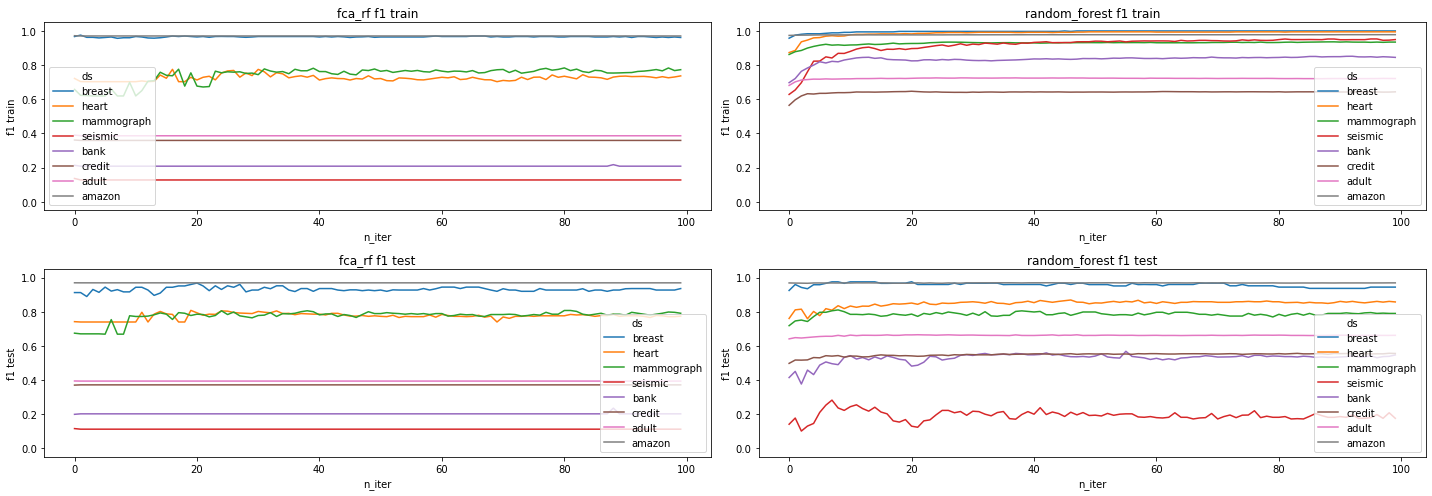

In [180]:
plt.figure(figsize=(20,7))
#for idx, tpl in enumerate([('fca_rf','accuracy train'),('random_forest','accuracy train'),('fca_rf','accuracy test'),('random_forest','accuracy test')]):
for idx, tpl in enumerate([('fca_rf','f1 train'),('random_forest','f1 train'),('fca_rf','f1 test'),('random_forest','f1 test')]):
#for idx, tpl in enumerate([('fca_rf','roc_auc train'),('random_forest','roc_auc train'),('fca_rf','roc_auc test'),('random_forest','roc_auc test')]):
    model, metric = tpl
    plt.subplot(2,2,idx+1)
    cds = stats_ds[(stats_ds['model_name']==model)]
    sns.lineplot(x='n_iter', y=metric, hue='ds', data=cds)
    plt.title(f"{model} {metric}")
    plt.ylim(-0.05,1+0.05)

plt.tight_layout()
plt.show()

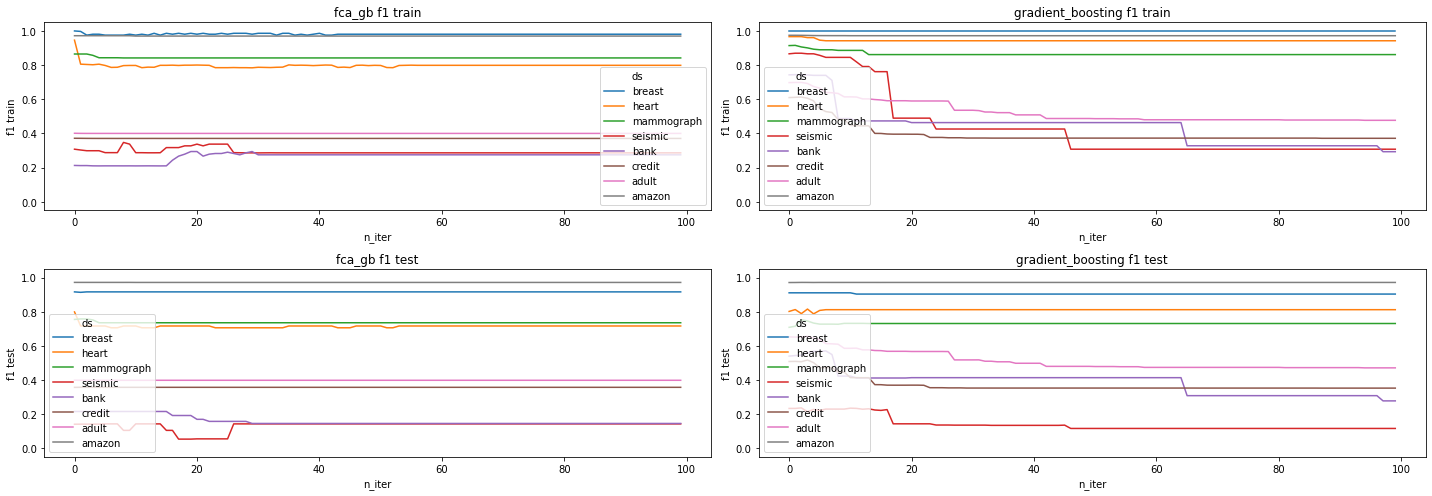

In [181]:
plt.figure(figsize=(20,7))
#for idx, tpl in enumerate([('fca_rf','accuracy train'),('random_forest','accuracy train'),('fca_rf','accuracy test'),('random_forest','accuracy test')]):
for idx, tpl in enumerate([('fca_gb','f1 train'),('gradient_boosting','f1 train'),('fca_gb','f1 test'),('gradient_boosting','f1 test')]):
#for idx, tpl in enumerate([('fca_rf','roc_auc train'),('random_forest','roc_auc train'),('fca_rf','roc_auc test'),('random_forest','roc_auc test')]):
    model, metric = tpl
    plt.subplot(2,2,idx+1)
    cds = stats_ds[(stats_ds['model_name']==model)]
    sns.lineplot(x='n_iter', y=metric, hue='ds', data=cds)
    plt.title(f"{model} {metric}")
    plt.ylim(-0.05,1+0.05)

plt.tight_layout()
plt.show()

In [182]:
d = {data_name: data['ds'].shape[0] for data_name, data in data_dict.items()}

In [183]:
stats_ds['ds_size'] = stats_ds['ds'].apply(lambda x: d[x])

In [188]:
stats_ds['ds_size'].unique()

array([  699,   920,   961,  2584,  4521, 30000, 32561, 32769])

In [189]:
stats_ds['concepts num'].max()

60721.0

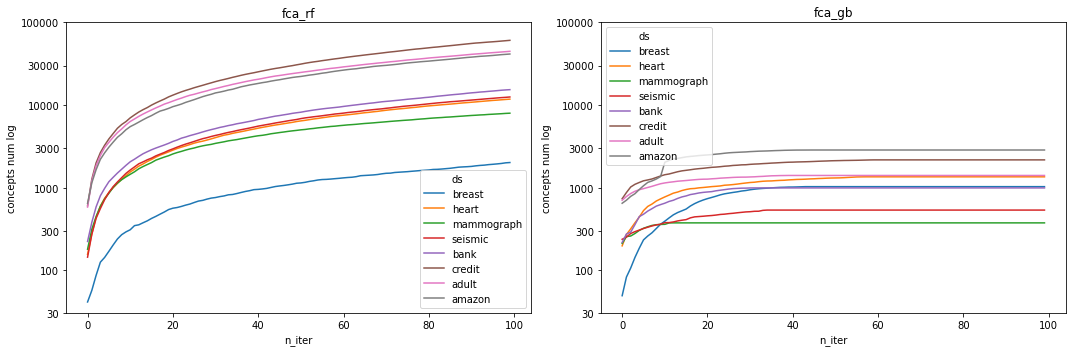

In [208]:
plt.figure(figsize=(15,5))
for idx, model in enumerate(['fca_rf','fca_gb']):
    plt.subplot(1,2,idx+1)
    cds = stats_ds[(stats_ds['model_name']==model)]
    cds['concepts num log'] = np.log1p(cds['concepts num'])
    cds['concepts_per_object'] = cds['concepts num']/cds['ds_size']
    sns.lineplot(x='n_iter', y='concepts num log', hue='ds', data=cds)
    plt.title(model)
    
    plt.ylim(np.log1p(30), np.log1p(100000))
    yticks = [30, 100,300,1000,3000,10000, 30000,100000]
    plt.yticks(np.log1p(yticks), yticks)
    
plt.tight_layout()
plt.show()

In [119]:
cds

,accuracy test,accuracy train,concepts num,ds,f1 test,f1 train,model_name,n_iter,new concepts num,roc_auc test,roc_auc train
0,0.960000,0.950382,15.0,breast,0.936937,0.929348,fca_rf,0.0,15.0,0.978917,0.967384
2,0.971429,0.961832,27.0,breast,0.956522,0.947368,fca_rf,1.0,12.0,0.993472,0.985410
4,0.960000,0.963740,37.0,breast,0.939130,0.949062,fca_rf,2.0,10.0,0.992872,0.987674
6,0.965714,0.965649,49.0,breast,0.948276,0.952880,fca_rf,3.0,12.0,0.992272,0.987937
8,0.954286,0.969466,61.0,breast,0.928571,0.957447,fca_rf,4.0,12.0,0.993247,0.984501
...,...,...,...,...,...,...,...,...,...,...,...
1590,0.939827,0.942830,492.0,amazon,0.968980,0.970574,fca_rf,95.0,5.0,0.563753,0.594483
1592,0.939827,0.942830,498.0,amazon,0.968980,0.970574,fca_rf,96.0,6.0,0.567376,0.598736
1594,0.939827,0.942830,501.0,amazon,0.968980,0.970574,fca_rf,97.0,3.0,0.571277,0.609416
1596,0.939827,0.942830,501.0,amazon,0.968980,0.970574,fca_rf,98.0,0.0,0.571277,0.609416


In [117]:
stats_ds

,accuracy test,accuracy train,concepts num,ds,f1 test,f1 train,model_name,n_iter,new concepts num,roc_auc test,roc_auc train
0,0.960000,0.950382,15.0,breast,0.936937,0.929348,fca_rf,0.0,15.0,0.978917,0.967384
1,0.971429,0.950382,NaN,breast,0.954955,0.929348,random_forest,0.0,NaN,0.946429,0.937854
2,0.971429,0.961832,27.0,breast,0.956522,0.947368,fca_rf,1.0,12.0,0.993472,0.985410
3,0.977143,0.963740,NaN,breast,0.964912,0.949602,random_forest,1.0,NaN,0.996474,0.981543
4,0.960000,0.963740,37.0,breast,0.939130,0.949062,fca_rf,2.0,10.0,0.992872,0.987674
...,...,...,...,...,...,...,...,...,...,...,...
1595,0.944343,0.945801,NaN,amazon,0.971303,0.972020,gradient_boosting,97.0,NaN,0.752300,0.856237
1596,0.944343,0.941772,2875.0,amazon,0.971364,0.970003,fca_gb,98.0,0.0,0.700104,0.770311
1597,0.944343,0.945801,NaN,amazon,0.971303,0.972020,gradient_boosting,98.0,NaN,0.752284,0.856210
1598,0.944343,0.941772,2875.0,amazon,0.971364,0.970003,fca_gb,99.0,0.0,0.700104,0.770311


In [ ]:
stats_rf_ds['ds']

In [85]:
stats_rf_ds

,accuracy test,accuracy train,concepts num,f1 test,f1 train,model_name,n_iter,new concepts num,roc_auc test,roc_auc train
0,0.942857,0.952290,13.0,0.905660,0.938272,fca_rf,0.0,13.0,0.985261,0.978837
1,0.954286,0.952290,NaN,0.923077,0.938272,random_forest,0.0,NaN,0.969793,0.973911
2,0.942857,0.958015,25.0,0.901961,0.943878,fca_rf,1.0,12.0,0.986395,0.983245
3,0.948571,0.958015,NaN,0.907216,0.943590,random_forest,1.0,NaN,0.976757,0.978272
4,0.960000,0.963740,37.0,0.929293,0.951899,fca_rf,2.0,12.0,0.984613,0.987395
...,...,...,...,...,...,...,...,...,...,...
2434,0.895594,0.898862,208.0,0.311696,0.376564,fca_rf,72.0,0.0,0.673959,0.720938
2435,0.898882,0.899794,NaN,0.397206,0.399634,random_forest,72.0,NaN,0.739724,0.742311
2436,0.895594,0.898770,209.0,0.321846,0.383814,fca_rf,73.0,1.0,0.671688,0.719208
2437,0.898882,0.899794,NaN,0.397608,0.400133,random_forest,73.0,NaN,0.739755,0.742311


In [84]:
len(stats_rf_ds)

2439

In [87]:
n_iters

100

In [86]:
len([x for data_name in data_names for x in [data_name]*n_iters*2])

1800

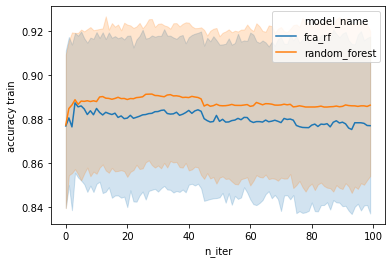

In [77]:
sns.lineplot(x='n_iter', y='accuracy train', hue='model_name',  data=stats_rf_ds)

In [75]:
stats_rf_ds

,accuracy test,accuracy train,concepts num,f1 test,f1 train,model_name,n_iter,new concepts num,roc_auc test,roc_auc train
0,0.942857,0.952290,13.0,0.905660,0.938272,fca_rf,0.0,13.0,0.985261,0.978837
1,0.954286,0.952290,NaN,0.923077,0.938272,random_forest,0.0,NaN,0.969793,0.973911
2,0.942857,0.958015,25.0,0.901961,0.943878,fca_rf,1.0,12.0,0.986395,0.983245
3,0.948571,0.958015,NaN,0.907216,0.943590,random_forest,1.0,NaN,0.976757,0.978272
4,0.960000,0.963740,37.0,0.929293,0.951899,fca_rf,2.0,12.0,0.984613,0.987395
...,...,...,...,...,...,...,...,...,...,...
2434,0.895594,0.898862,208.0,0.311696,0.376564,fca_rf,72.0,0.0,0.673959,0.720938
2435,0.898882,0.899794,NaN,0.397206,0.399634,random_forest,72.0,NaN,0.739724,0.742311
2436,0.895594,0.898770,209.0,0.321846,0.383814,fca_rf,73.0,1.0,0.671688,0.719208
2437,0.898882,0.899794,NaN,0.397608,0.400133,random_forest,73.0,NaN,0.739755,0.742311


# Production way

In [264]:
fcai = reload(fcai)

In [265]:
cntx_train = fcai.MultiValuedContext(X_train, objs=[str(x) for x in X_train.index], y_true=y_train, cat_attrs=cat_feats)
cntx_test = fcai.MultiValuedContext(X_test, objs=[str(x) for x in X_test.index], y_true=y_test, cat_attrs=cat_feats)
fm = fcai.FormalManager(cntx_train)

In [271]:
fm.construct_concepts(algo='GradientForest', rf_params={'n_estimators':5, 'max_depth':None}, n_layers=2)

In [272]:
preds = fm.predict_context(cntx_test).flatten()

In [273]:
roc_auc_score(y_test, preds)

0.989937641723356